# Import Libraries

In [1]:
# Pandas & Numpy 
import pandas as pd 
import numpy as np 

# Suprise & Recommenders 
import surprise 
from recommenders.models.surprise.surprise_utils import compute_ranking_predictions, predict
from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k

# Reading Data

In [2]:
# Read Train & Test Data
train = pd.read_csv("../../00_Data/rec_sys_binary_train_mixed.csv", index_col=0)
test = pd.read_csv("../../00_Data/rec_sys_binary_test_mixed.csv", index_col=0)

In [3]:
# Check Shapes
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (193076, 3)
Shape of Test: 	 (48269, 3)


# Data Preparation: Value of Purchase

In [27]:
# Change values of purchased to 5
#train['purchased'] = 1
#test['purchased'] = 1

In [4]:
# Sanity Check with Describe 
train.purchased.describe()

count    287957.000000
mean          0.720524
std           0.448742
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: purchased, dtype: float64

# Preparation of Train Dataset for Surprise Models



In [4]:
# Reader 
reader = surprise.Reader(rating_scale=(0,1))

# Build Train Set from Custom Dataset
train_set = surprise.Dataset.load_from_df(train[['CustomerID', 'StockCode', 'purchased']], reader=reader).build_full_trainset()

# Baseline Model

In [5]:
# Delete Model first 
try:
    del(basemodel)
except:
    pass

# Create Object for Model
basemodel = surprise.NMF(random_state=0, verbose=False, n_factors=10, n_epochs=50, reg_pu=0.1, reg_qi=0.1)

# Fit Model
basemodel.fit(train_set)

# Prediction: Test Set only

In [6]:
# Predict Test Only
test_pred = predict(basemodel, test, usercol='CustomerID', itemcol='StockCode')

In [7]:
# Check Range of predicions
test_pred.prediction.describe()

count    48269.000000
mean         0.621765
std          0.197796
min          0.067672
25%          0.475925
50%          0.644721
75%          0.779760
max          1.000000
Name: prediction, dtype: float64

In [8]:
# Convert Predictions
test_pred['prediction'] = np.where((test_pred['prediction']>0.5), 1,0)

In [9]:
# Check Distribution
test_pred['prediction'].value_counts()

1    34713
0    13556
Name: prediction, dtype: int64

In [10]:
# Sort Index of both Datasets to use Accuracy Score 
test = test.sort_values(by=['CustomerID', 'StockCode'])
test_pred = test_pred.sort_values(by=['CustomerID', 'StockCode'])

# Reset indeces for both DataFrames
test = test.reset_index(drop=True)
test_pred = test_pred.reset_index(drop=True)

In [11]:
# First Reorder columns for test 
test = test[['CustomerID', 'StockCode', 'purchased']]
# Head of Test
test.head()

,CustomerID,StockCode,purchased
0,12347,21035,1
1,12347,21041,1
2,12347,21064,1
3,12347,21307,0
4,12347,21719,0


In [12]:
# Head of Test_pred - Compare Index with test.head() above 
test_pred.head()

,CustomerID,StockCode,prediction
0,12347,21035,1
1,12347,21041,1
2,12347,21064,0
3,12347,21307,0
4,12347,21719,0


In [13]:
# Import Accuracy 
from sklearn.metrics import accuracy_score

# Accuracy all instances 
accuracy_score(test.purchased, test_pred.prediction)

0.7681534732436968

In [14]:
# Accuracy on positive Test only
test_positive = test[test['purchased']==1]
test_positive_pred = test_positive.merge(test_pred, on=['CustomerID', 'StockCode'], how='left', indicator=True)
test_positive_pred.purchased.value_counts()
# Accuracy 
accuracy_score(test_positive_pred.purchased, test_positive_pred.prediction)


0.8405037637521714

# Prediction: Top N

In [15]:
# Predict All Pairs of Users & Items that are NOT in the Trainset 
predictions = compute_ranking_predictions(basemodel, train, usercol='CustomerID', itemcol='StockCode', remove_seen=True)

In [16]:
# Check first five rows
predictions.head()

,CustomerID,StockCode,prediction
193076,16701,22030,0.726466
193077,16701,22960,0.805785
193078,16701,21509,0.676593
193079,16701,22810,0.537189
193080,16701,22780,0.616707


In [17]:
# Filter Test for purchased items only
test = test[test['purchased']==1]

In [18]:
# Write function to filter out top N 
def filter_top_n(predictions: pd.DataFrame, n: int) -> pd.DataFrame:
    
    # Group the dataframe by 'CustomerID', and for each group, sort by 'prediction' in descending order, then take the top N rows
    top_n_per_customer = predictions.groupby('CustomerID', group_keys=False).apply(lambda group: group.sort_values('prediction', ascending=False).head(n))
    
    return top_n_per_customer

# Filter Top 10 
top_10 = filter_top_n(predictions, 10)

# Filter Top 20 
top_20 = filter_top_n(predictions, 20)

In [19]:
# Evaluate Precision at 10 
eval_precision_10 = precision_at_k(test, top_10, col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
print('precision at 10 \t:', eval_precision_10)

# Evaluate Recall at 10 
eval_recall_10 = recall_at_k(test, top_10,col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
print('recall at 10 \t:', eval_recall_10)

precision at 10 	: 0.047769204964776935
recall at 10 	: 0.04870063553297101


In [20]:
# Evaluate Precision at 20 
eval_precision_20 = precision_at_k(test, top_20, col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
print('precision at 20 \t:', eval_precision_20)

# Evaluate Recall at 20 
eval_recall_20 = recall_at_k(test, top_20,col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
print('recall at 20 \t:', eval_recall_20)

precision at 20 	: 0.04109359275410937
recall at 20 	: 0.07889946676172999


# Hyperparameter Tuning

In [21]:
# Define Set of Hyperparameters 
n_factors = [5, 10, 15, 20, 100]
biases = [False]
reg_all = [0.01]
lr_det = [0.001]

# Initiate Lists 
factor_nr = []
regulation_all = []
lr_all = []
bias_all = []
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []

for factors in n_factors:
    for regulation in reg_all:
        for learning in lr_det:
            for bias in biases:
                try:
                    del(model)
                except:
                    pass 
                # Define Model 
                model = surprise.NMF(random_state=0,
                                    verbose=False,
                                    biased=False,
                                    n_factors=factors,
                                    n_epochs=50,
                                    reg_bi=regulation,
                                    reg_bu=regulation,
                                    lr_bi=learning,
                                    lr_bu=learning)
                
                # Fit model
                model.fit(train_set)
                
                # Predict All Pairs of Users & Items that are NOT in the Trainset 
                predictions = compute_ranking_predictions(model, test, usercol='CustomerID', itemcol='StockCode')
                
                # Filter Top 10 & 20 
                top_10 = filter_top_n(predictions, 10)
                top_20 = filter_top_n(predictions, 20)
                
                # Evaluate Recall at 10 
                eval_recall_10 = recall_at_k(test, top_10,col_user="CustomerID", col_item="StockCode",
                                            col_rating="purchased", col_prediction="prediction", 
                                            relevancy_method="top_k", k=10)
                # Evaluate Recall at 20 
                eval_recall_20 = recall_at_k(test, top_20,col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
                
                # Evaluate Precision at 10 
                eval_precision_10 = precision_at_k(test, top_10, col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
                # Evaluate Precision at 20 
                eval_precision_20 = precision_at_k(test, top_20, col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20) 
                
                print("recall at for", factors, "factors: \t", eval_recall_10)
                factor_nr.append(factors)
                regulation_all.append(regulation)
                lr_all.append(learning)
                bias_all.append(bias)
                recall_10.append(eval_recall_10)
                recall_20.append(eval_recall_20)
                precision_10.append(eval_precision_10)
                precision_20.append(eval_precision_20)
                

recall at for 5 factors: 	 0.031627075887257834
recall at for 10 factors: 	 0.036644784713595495
recall at for 15 factors: 	 0.03893487834318024
recall at for 20 factors: 	 0.043763983992539425
recall at for 100 factors: 	 0.0551799799261397


In [22]:
dict_param = {
    "factor": factor_nr,
    "regulation_all": regulation_all,
    "learning_rate_all": lr_all,
    "bias" : bias_all,
    "recall_10": recall_10,
    "recall_20": recall_20,
    "precision_10" : precision_10,
    "precision_20" : precision_20
}

In [23]:
df_param = pd.DataFrame(dict_param)
df_param.head()

,factor,regulation_all,learning_rate_all,bias,recall_10,recall_20,precision_10,precision_20
0,5,0.01,0.001,False,0.031627,0.058504,0.032539,0.029705
1,10,0.01,0.001,False,0.036645,0.063808,0.035626,0.031768
2,15,0.01,0.001,False,0.038935,0.070808,0.036934,0.033395
3,20,0.01,0.001,False,0.043764,0.079845,0.039450,0.036364
4,100,0.01,0.001,False,0.055180,0.096897,0.046260,0.041312


In [24]:
df_param.describe()

,factor,regulation_all,learning_rate_all,recall_10,recall_20,precision_10,precision_20
count,5.000000,5.00,5.000,5.000000,5.000000,5.000000,5.000000
mean,30.000000,0.01,0.001,0.041230,0.073972,0.038162,0.034509
std,39.528471,0.00,0.000,0.008938,0.015105,0.005167,0.004515
min,5.000000,0.01,0.001,0.031627,0.058504,0.032539,0.029705
25%,10.000000,0.01,0.001,0.036645,0.063808,0.035626,0.031768
50%,15.000000,0.01,0.001,0.038935,0.070808,0.036934,0.033395
75%,20.000000,0.01,0.001,0.043764,0.079845,0.039450,0.036364
max,100.000000,0.01,0.001,0.055180,0.096897,0.046260,0.041312


# Tuning 2 

In [25]:
# Define Set of Hyperparameters 
n_factors = [50, 100, 150]
reg_all = [0.01]
lr_det = [0.001]

# Initiate Lists 
factor_nr = []
regulation_all = []
lr_all = []
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []

for factors in n_factors:
    for regulation in reg_all:
        for learning in lr_det:
            try:
                del(model)
            except:
                pass 
            # Define Model 
            model = surprise.NMF(random_state=0,
                                verbose=False,
                                biased=False,
                                n_factors=factors,
                                n_epochs=50,
                                reg_bi=regulation,
                                reg_bu=regulation,
                                lr_bi=learning,
                                lr_bu=learning)
            
            # Fit model
            model.fit(train_set)
            
            # Predict All Pairs of Users & Items that are NOT in the Trainset 
            predictions = compute_ranking_predictions(model, test, usercol='CustomerID', itemcol='StockCode')
            
            # Filter Top 10 & 20 
            top_10 = filter_top_n(predictions, 10)
            top_20 = filter_top_n(predictions, 20)
            
            # Evaluate Recall at 10 
            eval_recall_10 = recall_at_k(test, top_10,col_user="CustomerID", col_item="StockCode",
                                        col_rating="purchased", col_prediction="prediction", 
                                        relevancy_method="top_k", k=10)
            # Evaluate Recall at 20 
            eval_recall_20 = recall_at_k(test, top_20,col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=20)
            
            # Evaluate Precision at 10 
            eval_precision_10 = precision_at_k(test, top_10, col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=10)
            # Evaluate Precision at 20 
            eval_precision_20 = precision_at_k(test, top_20, col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=20) 
            
            print("recall at for", factors, "factors: \t", eval_recall_10)
            factor_nr.append(factors)
            regulation_all.append(regulation)
            lr_all.append(learning)
            recall_10.append(eval_recall_10)
            recall_20.append(eval_recall_20)
            precision_10.append(eval_precision_10)
            precision_20.append(eval_precision_20)
            

recall at for 50 factors: 	 0.04982163457446326
recall at for 100 factors: 	 0.0551799799261397
recall at for 150 factors: 	 0.05581132077049418


In [26]:
dict_param2 = {
    "factor": factor_nr,
    "regulation_all": regulation_all,
    "learning_rate_all": lr_all,
    "recall_10": recall_10,
    "recall_20": recall_20,
    "precision_10" : precision_10,
    "precision_20" : precision_20
}

df_param2 = pd.DataFrame(dict_param2)
df_param2.head()

,factor,regulation_all,learning_rate_all,recall_10,recall_20,precision_10,precision_20
0,50,0.01,0.001,0.049822,0.089028,0.043710,0.039601
1,100,0.01,0.001,0.055180,0.096897,0.046260,0.041312
2,150,0.01,0.001,0.055811,0.099030,0.046796,0.042486


# Tuning 3

In [29]:
# Define Set of Hyperparameters 
n_factors = [100, 110, 120, 130, 140, 150, 160]
reg_all = [0.01]
lr_det = [0.001]

# Initiate Lists 
factor_nr = []
regulation_all = []
lr_all = []
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []

for factors in n_factors:
    for regulation in reg_all:
        for learning in lr_det:
            try:
                del(model)
            except:
                pass 
            # Define Model 
            model = surprise.NMF(random_state=0,
                                verbose=False,
                                biased=False,
                                n_factors=factors,
                                n_epochs=50,
                                reg_bi=regulation,
                                reg_bu=regulation,
                                lr_bi=learning,
                                lr_bu=learning)
            
            # Fit model
            model.fit(train_set)
            
            # Predict All Pairs of Users & Items that are NOT in the Trainset 
            predictions = compute_ranking_predictions(model, test, usercol='CustomerID', itemcol='StockCode')
            
            # Filter Top 10 & 20 
            top_10 = filter_top_n(predictions, 10)
            top_20 = filter_top_n(predictions, 20)
            
            # Evaluate Recall at 10 
            eval_recall_10 = recall_at_k(test, top_10,col_user="CustomerID", col_item="StockCode",
                                        col_rating="purchased", col_prediction="prediction", 
                                        relevancy_method="top_k", k=10)
            # Evaluate Recall at 20 
            eval_recall_20 = recall_at_k(test, top_20,col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=20)
            
            # Evaluate Precision at 10 
            eval_precision_10 = precision_at_k(test, top_10, col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=10)
            # Evaluate Precision at 20 
            eval_precision_20 = precision_at_k(test, top_20, col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=20) 
            
            print("recall at for", factors, "factors: \t", eval_recall_10)
            factor_nr.append(factors)
            regulation_all.append(regulation)
            lr_all.append(learning)
            recall_10.append(eval_recall_10)
            recall_20.append(eval_recall_20)
            precision_10.append(eval_precision_10)
            precision_20.append(eval_precision_20)

recall at for 100 factors: 	 0.0551799799261397
recall at for 110 factors: 	 0.05681274594750437
recall at for 120 factors: 	 0.056015557086465426
recall at for 130 factors: 	 0.05695531594865067
recall at for 140 factors: 	 0.05640340090781129
recall at for 150 factors: 	 0.05581132077049418
recall at for 160 factors: 	 0.05764855656963745


In [30]:
dict_param3 = {
    "factor": factor_nr,
    "regulation_all": regulation_all,
    "learning_rate_all": lr_all,
    "recall_10": recall_10,
    "recall_20": recall_20,
    "precision_10" : precision_10,
    "precision_20" : precision_20
}

df_param3 = pd.DataFrame(dict_param3)
df_param3.head()

,factor,regulation_all,learning_rate_all,recall_10,recall_20,precision_10,precision_20
0,100,0.01,0.001,0.055180,0.096897,0.046260,0.041312
1,110,0.01,0.001,0.056813,0.102839,0.046998,0.042217
2,120,0.01,0.001,0.056016,0.099061,0.046327,0.041345
3,130,0.01,0.001,0.056955,0.101330,0.046830,0.042553
4,140,0.01,0.001,0.056403,0.100752,0.047031,0.042486


# Tuning 4

In [32]:
# Define Set of Hyperparameters 
n_factors = [156, 157, 158, 159, 160, 161, 162, 163, 164]
reg_all = [0.01]
lr_det = [0.001]

# Initiate Lists 
factor_nr = []
regulation_all = []
lr_all = []
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []

for factors in n_factors:
    for regulation in reg_all:
        for learning in lr_det:
            try:
                del(model)
            except:
                pass 
            # Define Model 
            model = surprise.NMF(random_state=0,
                                verbose=False,
                                biased=False,
                                n_factors=factors,
                                n_epochs=50,
                                reg_bi=regulation,
                                reg_bu=regulation,
                                lr_bi=learning,
                                lr_bu=learning)
            
            # Fit model
            model.fit(train_set)
            
            # Predict All Pairs of Users & Items that are NOT in the Trainset 
            predictions = compute_ranking_predictions(model, test, usercol='CustomerID', itemcol='StockCode')
            
            # Filter Top 10 & 20 
            top_10 = filter_top_n(predictions, 10)
            top_20 = filter_top_n(predictions, 20)
            
            # Evaluate Recall at 10 
            eval_recall_10 = recall_at_k(test, top_10,col_user="CustomerID", col_item="StockCode",
                                        col_rating="purchased", col_prediction="prediction", 
                                        relevancy_method="top_k", k=10)
            # Evaluate Recall at 20 
            eval_recall_20 = recall_at_k(test, top_20,col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=20)
            
            # Evaluate Precision at 10 
            eval_precision_10 = precision_at_k(test, top_10, col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=10)
            # Evaluate Precision at 20 
            eval_precision_20 = precision_at_k(test, top_20, col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=20) 
            
            print("recall at for", factors, "factors: \t", eval_recall_10)
            factor_nr.append(factors)
            regulation_all.append(regulation)
            lr_all.append(learning)
            recall_10.append(eval_recall_10)
            recall_20.append(eval_recall_20)
            precision_10.append(eval_precision_10)
            precision_20.append(eval_precision_20)

recall at for 156 factors: 	 0.058220338529257856
recall at for 157 factors: 	 0.05842356982270454
recall at for 158 factors: 	 0.05653611699575816
recall at for 159 factors: 	 0.059575591070037216
recall at for 160 factors: 	 0.05764855656963745
recall at for 161 factors: 	 0.058454000619800175
recall at for 162 factors: 	 0.05667442205405311
recall at for 163 factors: 	 0.05666300210626157
recall at for 164 factors: 	 0.058424013075398434


In [33]:
dict_param4 = {
    "factor": factor_nr,
    "regulation_all": regulation_all,
    "learning_rate_all": lr_all,
    "recall_10": recall_10,
    "recall_20": recall_20,
    "precision_10" : precision_10,
    "precision_20" : precision_20
}

df_param4 = pd.DataFrame(dict_param4)
df_param4.sort_values(by='recall_10', ascending=False)

,factor,regulation_all,learning_rate_all,recall_10,recall_20,precision_10,precision_20
3,159,0.01,0.001,0.059576,0.103506,0.048742,0.043173
5,161,0.01,0.001,0.058454,0.101336,0.047736,0.042855
8,164,0.01,0.001,0.058424,0.101293,0.049178,0.042955
1,157,0.01,0.001,0.058424,0.102195,0.047467,0.042435
0,156,0.01,0.001,0.058220,0.103709,0.047568,0.043492
4,160,0.01,0.001,0.057649,0.102503,0.047803,0.043173
6,162,0.01,0.001,0.056674,0.101743,0.047467,0.042687
7,163,0.01,0.001,0.056663,0.100356,0.047803,0.042704
2,158,0.01,0.001,0.056536,0.099564,0.047165,0.042184


# Best Model: Accuracy on Test

In [34]:
# Create Object for Model
best_model = surprise.NMF(random_state=0,
                        verbose=False,
                        biased=False,
                        n_factors=159,
                        n_epochs=50,
                        reg_bi=0.01,
                        reg_bu=0.01,
                        lr_bi=0.001,
                        lr_bu=0.001)

# Fit the base_model
best_model.fit(train_set)

# Make Predictions
test_pred = predict(best_model, test, usercol='CustomerID', itemcol='StockCode')

# Convert Predictions
test_pred['prediction'] = np.where((test_pred['prediction']>0.5), 1,0)

# Sort Index of both Datasets to use Accuracy Score 
test = test.sort_values(by=['CustomerID', 'StockCode'])
test_pred = test_pred.sort_values(by=['CustomerID', 'StockCode'])

# Reset indeces for both DataFrames
test = test.reset_index(drop=True)
test_pred = test_pred.reset_index(drop=True)

# Accuracy 
accuracy_score(test.purchased, test_pred.prediction)

0.8964099594672843

In [35]:
test.purchased.value_counts()

1    34540
Name: purchased, dtype: int64

# Visualizations

In [36]:
# Import Vizualization Libraries
import seaborn as sns 
from matplotlib import pyplot as plt
import plotly.express as px

/var/folders/bs/ht_t1wp94tl3wt5xhchcxq2m0000gn/T/ipykernel_77463/995872618.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,z, cmap='viridis', marker='o', s=40)


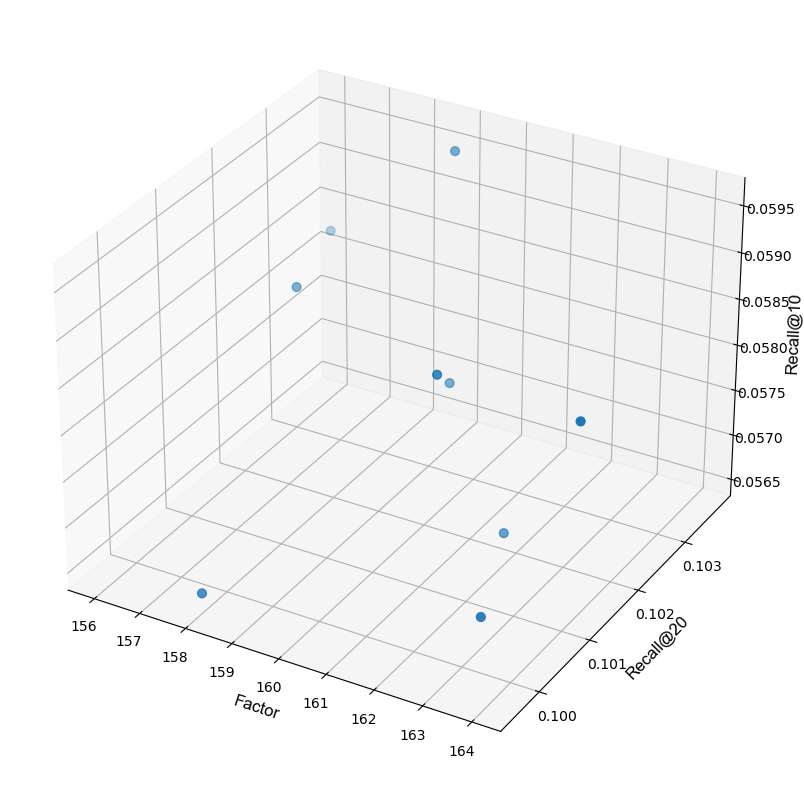

In [37]:
fig = plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 10})
ax = fig.add_subplot(projection='3d')

x, y, z = df_param4.factor, df_param4.recall_20, df_param4.recall_10
ax.set_xlabel('Factor', fontname='Arial', fontsize=12)
ax.set_zlabel('Recall@10',fontname='Arial', fontsize=12)
ax.set_ylabel('Recall@20',fontname='Arial', fontsize=12)
ax.scatter(x,y,z, cmap='viridis', marker='o', s=40)
#ax.set_title('Number of Factors in the latent Space for the NMF model', fontname='Arial', fontsize=15)
plt.show()
